# Deep Learning – Assignment 1: Single-Word Audio Classification 

## Library

In [1]:
!nvidia-smi

Mon Apr 14 13:58:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0             19W /   75W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.utils.data import Dataset, DataLoader

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Extract Audio

In [4]:
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        self.label_map = {}

        for idx, label in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                self.label_map[idx] = label
                for file in os.listdir(label_path):
                    if file.endswith(".wav"):
                        self.samples.append(os.path.join(label_path, file))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        feature = np.mean(mfcc.T, axis=0)
        return torch.tensor(feature, dtype=torch.float32), label

In [ ]:
train_dataset = AudioDataset("Deep_Learning/Asgmt 1/DataTraining")
test_dataset = AudioDataset("Deep_Learning/Asgmt 1/DataTesting")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training


In [6]:
class AudioFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
input_size = 13
num_classes = len(train_dataset.label_map)
model = AudioFNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Training loop
num_epochs = 30
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for features, labels in train_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/30], Loss: 1.2629, Accuracy: 0.6083
Epoch [2/30], Loss: 0.7370, Accuracy: 0.7000
Epoch [3/30], Loss: 0.5957, Accuracy: 0.7250
Epoch [4/30], Loss: 0.5740, Accuracy: 0.7667
Epoch [5/30], Loss: 0.5174, Accuracy: 0.7917
Epoch [6/30], Loss: 0.5083, Accuracy: 0.7750
Epoch [7/30], Loss: 0.5466, Accuracy: 0.8083
Epoch [8/30], Loss: 0.4963, Accuracy: 0.8083
Epoch [9/30], Loss: 0.4381, Accuracy: 0.8833
Epoch [10/30], Loss: 0.4211, Accuracy: 0.8500
Epoch [11/30], Loss: 0.3880, Accuracy: 0.8833
Epoch [12/30], Loss: 0.4433, Accuracy: 0.8500
Epoch [13/30], Loss: 0.3835, Accuracy: 0.8917
Epoch [14/30], Loss: 0.4118, Accuracy: 0.8917
Epoch [15/30], Loss: 0.4517, Accuracy: 0.8000
Epoch [16/30], Loss: 0.3741, Accuracy: 0.8667
Epoch [17/30], Loss: 0.3820, Accuracy: 0.8917
Epoch [18/30], Loss: 0.3551, Accuracy: 0.9167
Epoch [19/30], Loss: 0.3868, Accuracy: 0.8750
Epoch [20/30], Loss: 0.3255, Accuracy: 0.8917
Epoch [21/30], Loss: 0.3929, Accuracy: 0.8750
Epoch [22/30], Loss: 0.3251, Accuracy: 0.89

## Result


In [11]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Accuracy
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Test Accuracy: {overall_acc:.4f}")


Overall Test Accuracy: 0.5722


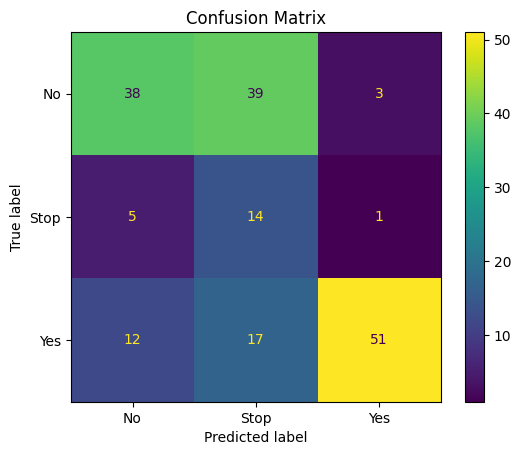

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[train_dataset.label_map[i] for i in range(num_classes)]).plot()
plt.title("Confusion Matrix")
plt.show()

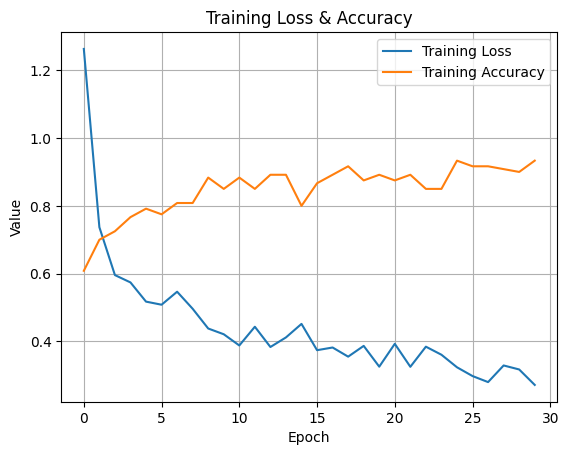

In [12]:
# Training Curves
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss & Accuracy")
plt.legend()
plt.grid(True)
plt.show()